In [1]:
import numpy as np
import pandas as pd
import math
from scipy.stats import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

## Question 1

Text(0, 0.5, 'Credit Spread')

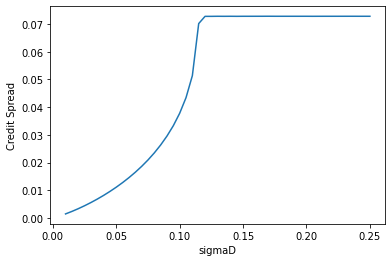

In [161]:
def f_sigmaD(sigmaV, D, E, r, T):
    V = E + D
    d1 = (math.log(V / D) + (r + 0.5 * sigmaV ** 2) * T) / (sigmaV * math.sqrt(T))
    return sigmaV * (1 + (E / D)) *  norm.cdf(-d1)
 
""" 
def fonction_objectif(sigmaV, D, E, r, T, sigmaD):
    sigmaD_estime = f_sigmaD(sigmaV, D, E, r, T)[0]
    return (sigmaD - sigmaD_estime) ** 2

def get_sigmaV(D, E, r, T, sigmaD_observed):
    result = minimize(lambda sigmaV: fonction_objectif(sigmaV, D, E, r, T, sigmaD_observed), x0=[0.2])
    return result.x[0]
"""


D = 60# Debt
E = 100   # Equity
r = 0.00  # Risk-free rate
T = 10 # Time to maturity


# Calculate Credit spread
def f_get_creditSpread(D, E, r, T, sigmaV):
    V = D + E
    d1 = (math.log(V / D) + (r + 0.5 * sigmaV ** 2) * T) / (sigmaV * math.sqrt(T))
    d2 = d1 - (sigmaV * np.sqrt(T))
    return -(math.log(norm.cdf(d2) + V / D * np.exp(-r*T) * norm.cdf(-d1)))/ T


sigmaD = np.linspace(0.01, 0.25, 49)
sigmaV = [get_sigmaV(D, E, r, T, sigmaD_observed) for sigmaD_observed in sigmaD]
res = [f_get_creditSpread(D, E, r, T, sigmaV_tmp) for sigmaV_tmp in sigmaV]

plt.plot(sigmaD,  res)
plt.xlabel("sigmaD")
plt.ylabel("Credit Spread")



#### Cook Version

In [197]:
def d1(V, F, r, sigmaV, T):
    d1 = (math.log(V / F) + (r + 0.5 * sigmaV ** 2) * T) / (sigmaV * math.sqrt(T))
    return d1


def d2(d1, sigmaV, T):
    return  d1 - (sigmaV * np.sqrt(T))


def f_get_creditSpread2(V, F, r, sigmaV, T):
    d1_t = d1(V, F, r, sigmaV, T)
    d2_t = d2(d1_t, sigmaV, T)
    return (-1/T) * math.log(np.exp(-r * T) * norm.cdf(d2_t) + (V/F) * norm.cdf(-d1_t)) - r


# On fixe v à 1
def put_value(V, F, sigmaV, r, T):
    d1_t = d1(V, F, r, sigmaV, T)
    d2_t = d2(d1_t, sigmaV, T)
    return F * np.exp(-r * T) * norm.cdf(-d2_t) - V * norm.cdf(-d1_t)


def f_sigmaD2(V, F, sigmaV, r, T):
    P = put_value(V, F, sigmaV, r, T)
    d1_t = d1(V, F, r, sigmaV, T)
    D = F * np.exp(-r * T) - P
    return sigmaV * V * norm.cdf(-d1_t) / D

Text(0.5, 0, 'Sigma Dette')

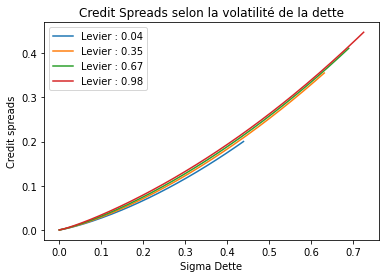

In [236]:
V_arr = [1/x for x in np.linspace(0.04, 0.98, 4)]
F = 1
T = 5
r = 0.05
sigmaV_array = np.linspace(0.01, 1.5 , 150)
for V in V_arr:
    plt.plot([f_sigmaD2(V, F, tmp, r, T) for tmp in sigmaV_array], [f_get_creditSpread2(V, F, r, tmp, T) for tmp in sigmaV_array], label = f"Levier : {round(1/V, 2)}")
plt.legend()
plt.title("Credit Spreads selon la volatilité de la dette")
plt.ylabel("Credit spreads")
plt.xlabel("Sigma Dette")